# Battery Forecasting with DeepAR

In this notebook we'll prevent battery outages using Amazon Sagemaker and [DeepAR Forecasting](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html).

"The Amazon SageMaker DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNN)."

Start by loading the required libraries and recovering stored data:

In [1]:
import pandas as pd
from matplotlib import pyplot

In [2]:
%store -r data

## Exploratory Data Analysis

Visualize the battery time series for a single device:

In [3]:
device_loc = 1
sample_device_id = data.iloc[device_loc]["device_id"]
sample_device_id

'8e4a851ed2317a249a0903f29d894361'

In [4]:
sample_data = data[data["device_id"] == sample_device_id]

In [5]:
battery = sample_data["battery"]

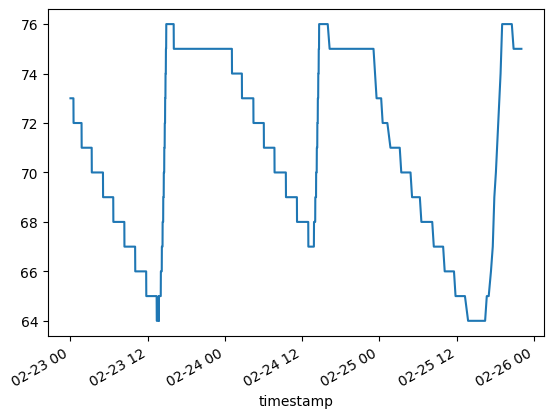

In [6]:
battery.plot()
pyplot.show()

## Time Series Resampling

The [DeepAR input format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput) requires data to be sampled at regular time intervals. Here is a sample input:


<code>{"start": "2009-11-01 00:00:00", "target": [4.3, "NaN", 5.1, ...], "cat": [0, 1], "dynamic_feat": [[1.1, 1.2, 0.5, ...]]}
{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [2, 3], "dynamic_feat": [[1.1, 2.05, ...]]}
{"start": "1999-01-30 00:00:00", "target": [2.0, 1.0], "cat": [1, 4], "dynamic_feat": [[1.3, 0.4]]}
</code>

In the dataset, we can see that the sample timestamps are no regularly spaced, but actualy reflects the observation time:

In [7]:
battery.tail()

timestamp
2020-02-25 20:50:37    75
2020-02-25 21:07:07    75
2020-02-25 21:23:15    75
2020-02-25 21:38:36    75
2020-02-25 22:03:11    75
Name: battery, dtype: int64

<Axes: xlabel='timestamp'>

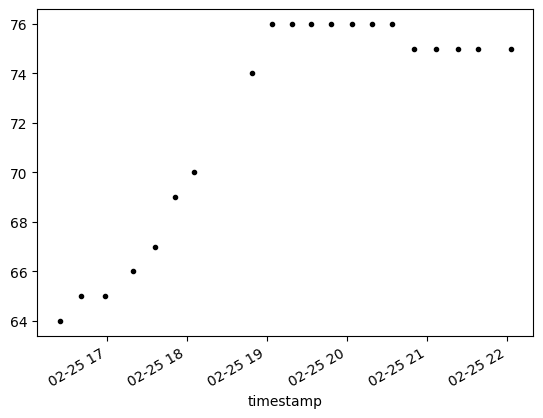

In [8]:
battery.tail(20).plot(style="k.")

Also, note that observation are taken about every 5 minutes, but changing little.
Pandas offers a convenient resampling function to create a uniform hourly dataset:

In [10]:
hourly = data[data["battery"] > 0]
hourly = (hourly.groupby("device_id")
          .battery
          .resample("h")
          .min())

/tmp/ipykernel_4672/400584912.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("H")


In [11]:
hourly

device_id                         timestamp          
0001495ce5f079703599a94c32dab2b0  2020-02-24 15:00:00    75.0
                                  2020-02-24 16:00:00    75.0
                                  2020-02-24 17:00:00    75.0
                                  2020-02-24 18:00:00    75.0
                                  2020-02-24 19:00:00    75.0
                                                         ... 
fffaee1fbb9c96703850f64d3262e843  2020-02-25 17:00:00    64.0
                                  2020-02-25 18:00:00    68.0
                                  2020-02-25 19:00:00    75.0
                                  2020-02-25 20:00:00    76.0
                                  2020-02-25 21:00:00    76.0
Name: battery, Length: 532029, dtype: float64

In [12]:
hourly = hourly.reset_index().set_index("timestamp")

In [46]:
hourly

,device_id,battery
timestamp,,
2020-02-24 15:00:00,0001495ce5f079703599a94c32dab2b0,75.0
2020-02-24 16:00:00,0001495ce5f079703599a94c32dab2b0,75.0
2020-02-24 17:00:00,0001495ce5f079703599a94c32dab2b0,75.0
2020-02-24 18:00:00,0001495ce5f079703599a94c32dab2b0,75.0
2020-02-24 19:00:00,0001495ce5f079703599a94c32dab2b0,75.0
...,...,...
2020-02-25 17:00:00,fffaee1fbb9c96703850f64d3262e843,64.0
2020-02-25 18:00:00,fffaee1fbb9c96703850f64d3262e843,68.0
2020-02-25 19:00:00,fffaee1fbb9c96703850f64d3262e843,75.0


Let's again visualize a sample tame series:

In [13]:
hsample = hourly[hourly["device_id"] == sample_device_id]

<Axes: xlabel='timestamp'>

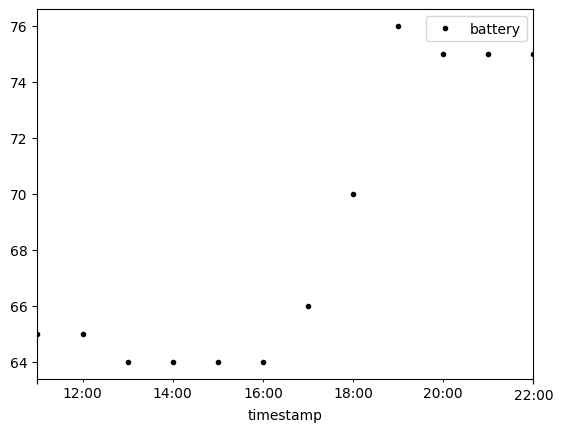

In [14]:
hsample.tail(12).plot(style="k.")

<Axes: xlabel='timestamp'>

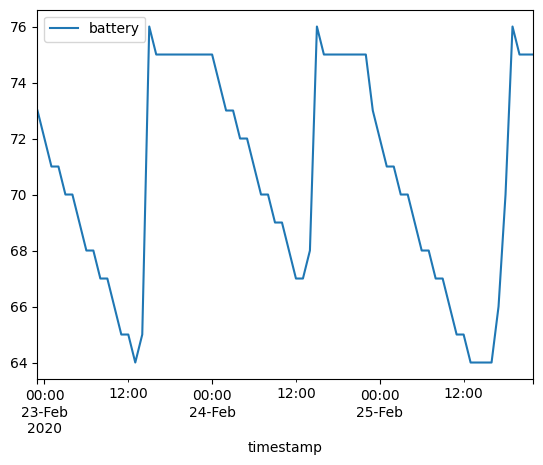

In [15]:
hsample.plot()

## Cross Validation

Take the last hours in the dataset for testing against predictions. This lets you evaluate how your model will perform on new data.

In [17]:
last_time = hourly.tail(1).index[0]
last_time

Timestamp('2020-02-25 21:00:00')

In [18]:
cut_time = last_time - pd.Timedelta('3 hour')
cut_time

Timestamp('2020-02-25 18:00:00')

In [19]:
train_set = hourly.loc[hourly.index <= cut_time]
train_set.tail()

,device_id,battery
timestamp,,
2020-02-25 14:00:00,fffaee1fbb9c96703850f64d3262e843,62.0
2020-02-25 15:00:00,fffaee1fbb9c96703850f64d3262e843,62.0
2020-02-25 16:00:00,fffaee1fbb9c96703850f64d3262e843,62.0
2020-02-25 17:00:00,fffaee1fbb9c96703850f64d3262e843,64.0
2020-02-25 18:00:00,fffaee1fbb9c96703850f64d3262e843,68.0


In [20]:
test_set = hourly.loc[hourly.index > cut_time]
test_set.head()

,device_id,battery
timestamp,,
2020-02-25 19:00:00,0001495ce5f079703599a94c32dab2b0,76.0
2020-02-25 20:00:00,0001495ce5f079703599a94c32dab2b0,76.0
2020-02-25 21:00:00,0001495ce5f079703599a94c32dab2b0,76.0
2020-02-25 19:00:00,00134c004e33e830e5dbce3355a485b9,76.0
2020-02-25 20:00:00,00134c004e33e830e5dbce3355a485b9,76.0


In [21]:
sample_train = train_set[train_set["device_id"] == sample_device_id]["battery"]
sample_test = test_set[test_set["device_id"] == sample_device_id]

In [22]:
sample_train.tail()

timestamp
2020-02-25 14:00:00    64.0
2020-02-25 15:00:00    64.0
2020-02-25 16:00:00    64.0
2020-02-25 17:00:00    66.0
2020-02-25 18:00:00    70.0
Name: battery, dtype: float64

In [23]:
sample_test.head()

,device_id,battery
timestamp,,
2020-02-25 19:00:00,8e4a851ed2317a249a0903f29d894361,76.0
2020-02-25 20:00:00,8e4a851ed2317a249a0903f29d894361,75.0
2020-02-25 21:00:00,8e4a851ed2317a249a0903f29d894361,75.0
2020-02-25 22:00:00,8e4a851ed2317a249a0903f29d894361,75.0


<Axes: xlabel='timestamp'>

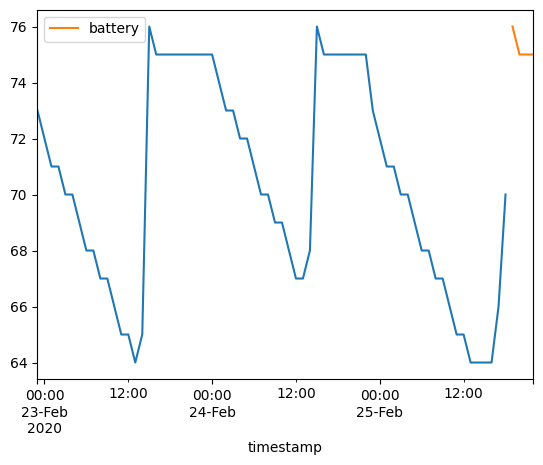

In [24]:
ax = sample_train.plot()
sample_test.plot(ax=ax)

## DeepAR Data Formatting

Convert the data from pandas DataFrame to the expected JSON Lines:

In [27]:
import json
import math

def df_to_tss(dataframe):
    df = dataframe.copy()
    df["timeindex"] = df.index
    cats = {}
    tss = {}
    for index, row in df.iterrows():
        target = row["battery"]
        if not(math.isnan(target)):
            identity = row["device_id"]
            cat = cats.get(identity)
            if not cat:
                cat = len(cats)
                start = str(row["timeindex"])
                ts = {
                    "start": start,
                    "cat": [cat],
                    "target": [],
                }
                cats[identity] = cat
                tss[cat] = ts
            ts = tss.get(cat)
            ts["target"].append(target)
    return tss

def tss_to_jsonl(tss):  
    result = ""
    for key, value in tss.items():
        jsonll = json.dumps(value)
        result += jsonll
        result += "\n"
    return result[:-1]

def df_to_jsonl(dataframe):
    return tss_to_jsonl(df_to_tss(dataframe))

In [28]:
import time
start = time.time()
jsonl = df_to_jsonl(train_set.head(100))
elapsed = time.time() - start
print(elapsed)
print(jsonl)

0.006284475326538086
{"start": "2020-02-24 15:00:00", "cat": [0], "target": [75.0]}
{"start": "2020-02-24 15:00:00", "cat": [1], "target": [76.0, 75.0, 75.0, 74.0, 74.0, 75.0, 75.0, 75.0, 73.0, 72.0, 71.0, 71.0, 70.0, 69.0, 69.0, 68.0, 68.0, 67.0, 66.0, 66.0, 65.0, 65.0, 64.0, 64.0, 63.0, 64.0, 65.0, 69.0]}
{"start": "2020-02-24 15:00:00", "cat": [2], "target": [75.0, 75.0, 75.0, 74.0, 74.0, 75.0, 75.0, 75.0, 73.0, 72.0, 71.0, 71.0, 70.0, 69.0, 68.0, 68.0, 67.0, 67.0, 66.0, 66.0, 65.0, 64.0, 64.0, 63.0, 63.0, 63.0, 65.0, 68.0]}
{"start": "2020-02-24 15:00:00", "cat": [3], "target": [76.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 73.0, 72.0, 72.0, 71.0, 70.0, 70.0, 69.0, 69.0]}


In [30]:
import time
start = time.time()

train_tss = df_to_tss(train_set)
train_jsonl = tss_to_jsonl(train_tss)

test_tss = df_to_tss(test_set)
test_jsonl = tss_to_jsonl(test_tss)

elapsed = time.time() - start
print(elapsed)

22.82814931869507


Save the json lines files locally:

In [31]:
import pathlib

prefix = "mt-battery-deepar"
input_path = "./{}/input".format(prefix)

train_path = "{}/train.json".format(input_path)
test_path = "{}/test.json".format(input_path)
(train_path,test_path)

('./mt-battery-deepar/input/train.json', './mt-battery-deepar/input/test.json')

In [32]:
import shutil

shutil.rmtree(input_path, ignore_errors=True)
pathlib.Path(input_path).mkdir(parents=True, exist_ok=True)

In [33]:
with open(train_path, "w") as text_file:
    print(train_jsonl, file=text_file)

with open(test_path, "w") as text_file:
    print(test_jsonl, file=text_file)

In [34]:
! ls -liah "{input_path}/"

total 5.0M
 637534592 drwxr-xr-x 2 gitpod gitpod   41 Mar  4 16:24 .
2384462632 drwxr-xr-x 3 gitpod gitpod   19 Mar  4 16:23 ..
 637534594 -rw-r--r-- 1 gitpod gitpod 1.3M Mar  4 16:24 test.json
 637534593 -rw-r--r-- 1 gitpod gitpod 3.8M Mar  4 16:24 train.json


Upload train and test sets to S3:

In [35]:
%store -r bucket

In [36]:
!aws s3 sync "{input_path}/" "s3://{bucket}/{prefix}/" --delete

upload: mt-battery-deepar/input/test.json to s3://mt-ml-workshop-0fsf9ksf/mt-battery-deepar/test.json
upload: mt-battery-deepar/input/train.json to s3://mt-ml-workshop-0fsf9ksf/mt-battery-deepar/train.json


In [37]:
!aws s3 ls "s3://{bucket}/{prefix}/" 

2024-03-04 16:24:09    1325499 test.json
2024-03-04 16:24:09    3906490 train.json


In [38]:
dar_input = {
    "train": "s3://{}/{}/train.json".format(bucket,prefix),
    "test": "s3://{}/{}/test.json".format(bucket,prefix)
}
dar_input

{'train': 's3://mt-ml-workshop-0fsf9ksf/mt-battery-deepar/train.json',
 'test': 's3://mt-ml-workshop-0fsf9ksf/mt-battery-deepar/test.json'}

## DeepAR Training

The different [ML instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/) in training lets you control how efficiently models learn.

"You can train DeepAR on both GPU and CPU instances and in both single and multi-machine settings. We recommend starting with a single CPU instance (for example, ml.c4.2xlarge or ml.c4.4xlarge), and switching to GPU instances and multiple machines only when necessary."

In [69]:
# train_instance_type='ml.c5.2xlarge' #Estimated Training Time: 10m
train_instance_type='ml.t3.medium'

In [74]:
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri

dar_image_name = sagemaker.image_uris.retrieve('forecasting-deepar', boto3.Session().region_name)
# dar_image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')
dar_image_name

'522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1'

In [79]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

dar_estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=dar_image_name,
    role=role,
    instance_count=1,
    instance_type=train_instance_type,
    base_job_name=prefix,
    output_path="s3://{}/{}/output/".format(bucket,prefix)
)

In [80]:
freq = 'H'
prediction_length = 4
context_length = 12

In [81]:

dar_hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
    "cardinality": "auto",
    "num_dynamic_feat":"ignore"
}
dar_estimator.set_hyperparameters(**dar_hyperparameters)

In [82]:
dar_estimator.fit(inputs=dar_input)

2021-05-11 07:10:08 Starting - Starting the training job...
2021-05-11 07:10:10 Starting - Launching requested ML instancesProfilerReport-1620717008: InProgress
.........
2021-05-11 07:12:07 Starting - Preparing the instances for training......
2021-05-11 07:13:07 Downloading - Downloading input data
2021-05-11 07:13:07 Training - Downloading the training image.....Arguments: train
[05/11/2021 07:13:46 INFO 140281140962944] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers': '2', 'test_quantiles': '[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]'}
[05/11/202

In [83]:
dar_job_name = dar_estimator.latest_training_job.name
dar_job_name

'mt-battery-deepar-2021-05-11-07-10-08-643'

## DeepAR Inference

In [84]:
infer_instance_type="ml.m5.large"

In [86]:
dar_endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=dar_job_name,
    initial_instance_count=1,
    instance_type=infer_instance_type,
    image_uri=dar_image_name,
    role=role
)
dar_endpoint_name

---------------!

'mt-battery-deepar-2021-05-11-07-10-08-643'

In [87]:
instances = []

In [88]:
instances.append(train_tss[1])

In [89]:
inference = {
    "instances": instances,
    "configuration": {
         "output_types": ["mean", "quantiles"],
         "quantiles": ["0.1","0.5", "0.9","0.99","0.999"]
    }
}

In [90]:
import json
inference_json = json.dumps(inference, indent=2)
print(inference_json)

{
  "instances": [
    {
      "start": "2020-02-24 15:00:00",
      "cat": [
        1
      ],
      "target": [
        76.0,
        75.0,
        75.0,
        74.0,
        74.0,
        75.0,
        75.0,
        75.0,
        73.0,
        72.0,
        71.0,
        71.0,
        70.0,
        69.0,
        69.0,
        68.0,
        68.0,
        67.0,
        66.0,
        66.0,
        65.0,
        65.0,
        64.0,
        64.0,
        63.0,
        64.0,
        65.0,
        69.0
      ]
    }
  ],
  "configuration": {
    "output_types": [
      "mean",
      "quantiles"
    ],
    "quantiles": [
      "0.1",
      "0.5",
      "0.9",
      "0.99",
      "0.999"
    ]
  }
}


In [111]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer



predictor = sagemaker.predictor.Predictor(
    dar_endpoint_name, 
    sagemaker_session=sagemaker_session, 
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer())
predictor

In [122]:
prediction = predictor.predict(inference)

In [124]:
prediction

{'predictions': [{'mean': [71.1284637451,
    72.3249282837,
    73.0628433228,
    72.9008026123],
   'quantiles': {'0.1': [68.7886962891,
     69.7614974976,
     70.4834442139,
     70.0815658569],
    '0.5': [71.0411529541, 72.1847610474, 73.2421646118, 72.8921966553],
    '0.9': [73.9268264771, 75.0553207397, 75.9048233032, 75.8751602173],
    '0.99': [76.6286773682, 77.4080276489, 77.9496307373, 80.5334777832],
    '0.999': [76.6286773682, 77.4080276489, 77.9496307373, 80.5334777832]}}]}

In [125]:
predictions = prediction["predictions"]
predictions

[{'mean': [71.1284637451, 72.3249282837, 73.0628433228, 72.9008026123],
  'quantiles': {'0.1': [68.7886962891,
    69.7614974976,
    70.4834442139,
    70.0815658569],
   '0.5': [71.0411529541, 72.1847610474, 73.2421646118, 72.8921966553],
   '0.9': [73.9268264771, 75.0553207397, 75.9048233032, 75.8751602173],
   '0.99': [76.6286773682, 77.4080276489, 77.9496307373, 80.5334777832],
   '0.999': [76.6286773682, 77.4080276489, 77.9496307373, 80.5334777832]}}]

## DeepAR Evaluation

In [126]:
pred0 = predictions[0]
pred0

{'mean': [71.1284637451, 72.3249282837, 73.0628433228, 72.9008026123],
 'quantiles': {'0.1': [68.7886962891,
   69.7614974976,
   70.4834442139,
   70.0815658569],
  '0.5': [71.0411529541, 72.1847610474, 73.2421646118, 72.8921966553],
  '0.9': [73.9268264771, 75.0553207397, 75.9048233032, 75.8751602173],
  '0.99': [76.6286773682, 77.4080276489, 77.9496307373, 80.5334777832],
  '0.999': [76.6286773682, 77.4080276489, 77.9496307373, 80.5334777832]}}

In [127]:

mean = pred0["mean"]
quantiles = pred0["quantiles"]
q01 = quantiles["0.1"]
q90 = quantiles["0.9"]

In [128]:
actual = sample_test["battery"][0:4].values
actual

array([76., 75., 75., 75.])

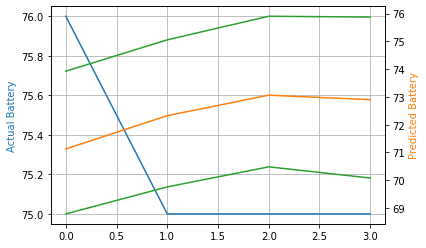

In [129]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Actual Battery', color='C0')
ax2.set_ylabel('Predicted Battery', color='C1')


ax1.plot(actual, color='C0')
ax2.plot(mean, color='C1')
ax2.plot(q01, color='C2')
ax2.plot(q90, color='C2')


# Motor Anomalies

Great job! Now let's work on detecting [motor anomalies](mt-motor-anomaly.ipynb).